In [ ]:
# ============================================================================
# IMPORTS
# ============================================================================
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Force CPU
import random

from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import classification_report
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import shutil
import gc
import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)
tf.random.set_seed(42)
plt.style.use("seaborn-v0_8-darkgrid")

print(f"TensorFlow: {tf.__version__}")
print(f"Devices: {[d.device_type for d in tf.config.list_physical_devices()]}")

TensorFlow: 2.19.0
Devices: ['CPU']


In [ ]:
# ============================================================================
# PATH CONFIGURATION
# ============================================================================
BASE_DATA_PATH = Path("/content/vehicle_project/raw_data")
SOURCE_IMAGES_DIR = BASE_DATA_PATH / "Images"
LABELS_CSV_PATH = BASE_DATA_PATH / "labels.csv"

PROJECT_ROOT = Path("/content/vehicle_project/vehicle_detection_project")
DATA_DIR = PROJECT_ROOT / "data"
CROPS_DIR = DATA_DIR / "crops"
MODEL_DIR = PROJECT_ROOT / "models"
RESULTS_DIR = PROJECT_ROOT / "results"

for d in [PROJECT_ROOT, DATA_DIR, CROPS_DIR, MODEL_DIR, RESULTS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print(f"Source: {SOURCE_IMAGES_DIR}")
print(f"Crops: {CROPS_DIR}")

Source: /content/vehicle_project/raw_data/Images
Crops: /content/vehicle_project/vehicle_detection_project/data/crops


In [ ]:
# ============================================================================
# LOAD LABELS & DEFINE CLASSES
# ============================================================================
CLASS_MERGE_MAP = {
    "articulated_truck": "truck", "single_unit_truck": "truck", "pickup_truck": "truck",
    "car": "car", "bus": "bus", "work_van": "van",
    "motorized_vehicle": "vehicle", "non-motorized_vehicle": "vehicle",
    "bicycle": "bicycle", "motorcycle": "motorcycle", "pedestrian": "pedestrian"
}

labels_df = pd.read_csv(LABELS_CSV_PATH, header=None,
                        names=["image_id", "vehicle_type", "x_min", "y_min", "x_max", "y_max"])
labels_df["vehicle_type"] = labels_df["vehicle_type"].map(lambda x: CLASS_MERGE_MAP.get(x, x))

CLASS_NAMES = sorted(labels_df["vehicle_type"].unique())
CLASS_MAP = {name: idx for idx, name in enumerate(CLASS_NAMES)}
NUM_CLASSES = len(CLASS_NAMES)

print(f"Loaded {len(labels_df):,} annotations")
print(f"Classes ({NUM_CLASSES}): {CLASS_NAMES}")

✓ Loaded 351,549 annotations
✓ Classes (8): ['bicycle', 'bus', 'car', 'motorcycle', 'pedestrian', 'truck', 'van', 'vehicle']


In [ ]:
# ============================================================================
# CREATE VEHICLE CROPS
# ============================================================================
def create_vehicle_crops(labels_df, source_dir, output_dir,
                         min_coverage=0.5, min_size=20, padding_ratio=0.1):
    """Create cropped vehicle images."""

    crops_file = output_dir / "crops_info.json"

    if crops_file.exists():
        with open(crops_file) as f:
            existing = json.load(f)
        print(f"Crops already exist ({len(existing):,} crops) - skipping")
        return existing

    print("="*60)
    print("CREATING VEHICLE CROPS")
    print("="*60)

    if output_dir.exists():
        shutil.rmtree(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    existing_images = {p.stem: p for p in source_dir.glob("*.jpg")}
    existing_images.update({p.stem: p for p in source_dir.glob("*.png")})

    crops_info = []
    stats = {"created": 0, "too_small": 0, "not_found": 0}
    total = len(labels_df)

    for idx, row in labels_df.iterrows():
        if idx % 50000 == 0:
            print(f"  Processing {idx:,}/{total:,} ({idx/total*100:.1f}%)...")

        image_id = f"{int(row['image_id']):08d}"

        if image_id not in existing_images:
            stats["not_found"] += 1
            continue

        img_path = existing_images[image_id]
        img = cv2.imread(str(img_path))
        if img is None:
            continue

        h, w = img.shape[:2]
        x_min = max(0, int(row["x_min"]))
        y_min = max(0, int(row["y_min"]))
        x_max = min(w, int(row["x_max"]))
        y_max = min(h, int(row["y_max"]))

        if x_max <= x_min or y_max <= y_min:
            continue

        coverage = ((x_max - x_min) * (y_max - y_min)) / (w * h) * 100
        if coverage < min_coverage or (x_max - x_min) < min_size or (y_max - y_min) < min_size:
            stats["too_small"] += 1
            continue

        pad_x = int((x_max - x_min) * padding_ratio)
        pad_y = int((y_max - y_min) * padding_ratio)
        x1p, y1p = max(0, x_min - pad_x), max(0, y_min - pad_y)
        x2p, y2p = min(w, x_max + pad_x), min(h, y_max + pad_y)

        crop = img[y1p:y2p, x1p:x2p]
        if crop.size == 0:
            continue

        crop_filename = f"crop_{stats['created']:06d}.jpg"
        cv2.imwrite(str(output_dir / crop_filename), crop)

        cw, ch = x2p - x1p, y2p - y1p
        rel_bbox = [
            max(0, min(1, (x_min - x1p) / cw)),
            max(0, min(1, (y_min - y1p) / ch)),
            max(0, min(1, (x_max - x1p) / cw)),
            max(0, min(1, (y_max - y1p) / ch))
        ]

        crops_info.append({
            "crop_filename": crop_filename,
            "label": str(row["vehicle_type"]),
            "bbox_in_crop": rel_bbox
        })
        stats["created"] += 1

    with open(crops_file, "w") as f:
        json.dump(crops_info, f)

    print(f"\n✓ Created: {stats['created']:,}, Skipped: {stats['too_small']:,}")
    return crops_info

crops_info = create_vehicle_crops(labels_df, SOURCE_IMAGES_DIR, CROPS_DIR, min_coverage=0.5)

✓ Crops already exist (10,146 crops) - skipping


In [ ]:
# ============================================================================
# SPLIT DATA
# ============================================================================
def split_crops_data(crops_info, output_dir, train_ratio=0.7, val_ratio=0.15):
    """Split crops into train/val/test."""

    train_file = output_dir / "train_crops.json"

    if train_file.exists():
        with open(train_file) as f:
            train = json.load(f)
        with open(output_dir / "val_crops.json") as f:
            val = json.load(f)
        with open(output_dir / "test_crops.json") as f:
            test = json.load(f)
        print(f"✓ Splits exist: Train={len(train):,}, Val={len(val):,}, Test={len(test):,}")
        return {"train": train, "val": val, "test": test}

    print("Splitting data...")
    crops_list = list(crops_info)
    np.random.shuffle(crops_list)

    n = len(crops_list)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)

    splits = {
        "train": crops_list[:n_train],
        "val": crops_list[n_train:n_train + n_val],
        "test": crops_list[n_train + n_val:]
    }

    for name, data in splits.items():
        with open(output_dir / f"{name}_crops.json", "w") as f:
            json.dump(data, f)
        print(f"✓ {name.capitalize()}: {len(data):,}")

    return splits

splits = split_crops_data(crops_info, DATA_DIR)

✓ Splits exist: Train=7,102, Val=1,521, Test=1,523


In [ ]:
# ============================================================================
# DATA GENERATOR CLASS
# ============================================================================

"""
DATA ARCHITECTURE: 1 image -> N crops -> N forward passes -> N bboxes. An alternative
architecture could use multiple object detection like YOLO/SSD for faster inference,
but it's more complex and slower training
"""

class CropDataGenerator(keras.utils.Sequence):
    """ Data generator for cropped vehicle images. """
    """ Create Keras Sequence generator to stream batches & shuffling before training each epoch. """

    # Loads crops_info.json metadata (crop filenames, labels, bboxes), data validation (filters out
    # invalid labels & bbox coords outside 0,1 range), and shuffles indices after each epoch training
    def __init__(self, crops_dir, crops_info_file, class_map, batch_size=32,
                 img_size=(224, 224), augment=False, include_bbox=True):
        self.crops_dir = Path(crops_dir)
        self.img_size = img_size
        self.batch_size = batch_size
        self.augment = augment
        self.class_map = class_map
        self.include_bbox = include_bbox

        with open(crops_info_file, "r") as f:
            self.crops_info = json.load(f)

        valid = [c for c in self.crops_info
                 if c["label"] in self.class_map
                 and all(0 <= v <= 1 for v in c.get("bbox_in_crop", [0,0,1,1]))]
        self.crops_info = valid

        self.indices = np.arange(len(self.crops_info))
        self.on_epoch_end()

    # defines how many batches = 1 eopoch of training
    def __len__(self):
        return max(1, int(np.ceil(len(self.crops_info) / self.batch_size)))

    # fetches data for a specific batch index
    def __getitem__(self, idx):
        start = idx * self.batch_size
        end = min(start + self.batch_size, len(self.crops_info))
        return self._generate_batch(self.indices[start:end])

    # shuffle indices after each epoch training
    def on_epoch_end(self):
        np.random.shuffle(self.indices)

    # Data Loading & Prep:
    # Reads image, converts colors from BGR -> RGB, resizes images to 224x224,
    # random augments, normalizes pixels, returns as x and y tuple/dict
    def _generate_batch(self, indices):
        batch_size = len(indices)
        images = np.zeros((batch_size, *self.img_size, 3), dtype=np.float32)
        labels = np.zeros(batch_size, dtype=np.int32)
        bboxes = np.zeros((batch_size, 4), dtype=np.float32)

        valid = 0
        for i in indices:
            info = self.crops_info[i]
            img = cv2.imread(str(self.crops_dir / info["crop_filename"]))
            if img is None:
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.img_size)

            if self.augment:
                if np.random.random() > 0.5:
                    img = np.fliplr(img).copy()
                if np.random.random() > 0.7:
                    img = np.clip(img * np.random.uniform(0.8, 1.2), 0, 255).astype(np.uint8)

            images[valid] = img.astype(np.float32) / 255.0
            labels[valid] = self.class_map.get(info["label"], 0)
            bboxes[valid] = np.array(info.get("bbox_in_crop", [0,0,1,1]), dtype=np.float32)
            valid += 1

        if valid == 0:
            valid = 1

        X = images[:valid]
        y_class = labels[:valid]
        y_bbox = bboxes[:valid]

        # Classification & Regression head
        if self.include_bbox:
            return X, {"bbox_output": y_bbox, "class_output": y_class}
        # Classification head only
        return X, y_class

In [ ]:
# ============================================================================
# MODEL ARCHITECTURE
# ============================================================================
def create_model(input_shape=(224, 224, 3), num_classes=NUM_CLASSES,
                 backbone="mobilenet", include_bbox=True):
    """Create vehicle detection model."""

    if backbone.lower() == "mobilenet":
        base_model = keras.applications.MobileNetV2(
            include_top=False, weights="imagenet", input_shape=input_shape
        )
        trainable_layers = 30
    elif backbone.lower() == "resnet50v2":
        base_model = keras.applications.ResNet50V2(
            include_top=False, weights="imagenet", input_shape=input_shape
        )
        trainable_layers = 30
    else:
        raise ValueError(f"Unknown backbone: {backbone}")

    for layer in base_model.layers[:-trainable_layers]:
        layer.trainable = False
    for layer in base_model.layers[-trainable_layers:]:
        layer.trainable = True

    inputs = keras.Input(shape=input_shape, name="image_input")
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.5)(x)

    outputs = {}
    outputs["class_output"] = layers.Dense(num_classes, activation="softmax", name="class_output")(x)

    if include_bbox:
        outputs["bbox_output"] = layers.Dense(4, activation="sigmoid", name="bbox_output")(x)

    return keras.Model(inputs=inputs, outputs=outputs, name=f"{backbone}_model")

VISUALIZING SPLIT SAMPLES
✓ All split directories and annotations found

Training set: 5797 annotation entries
  Unique images: 3654
Validation set: 1201 annotation entries
  Unique images: 784
Test set: 1200 annotation entries
  Unique images: 784


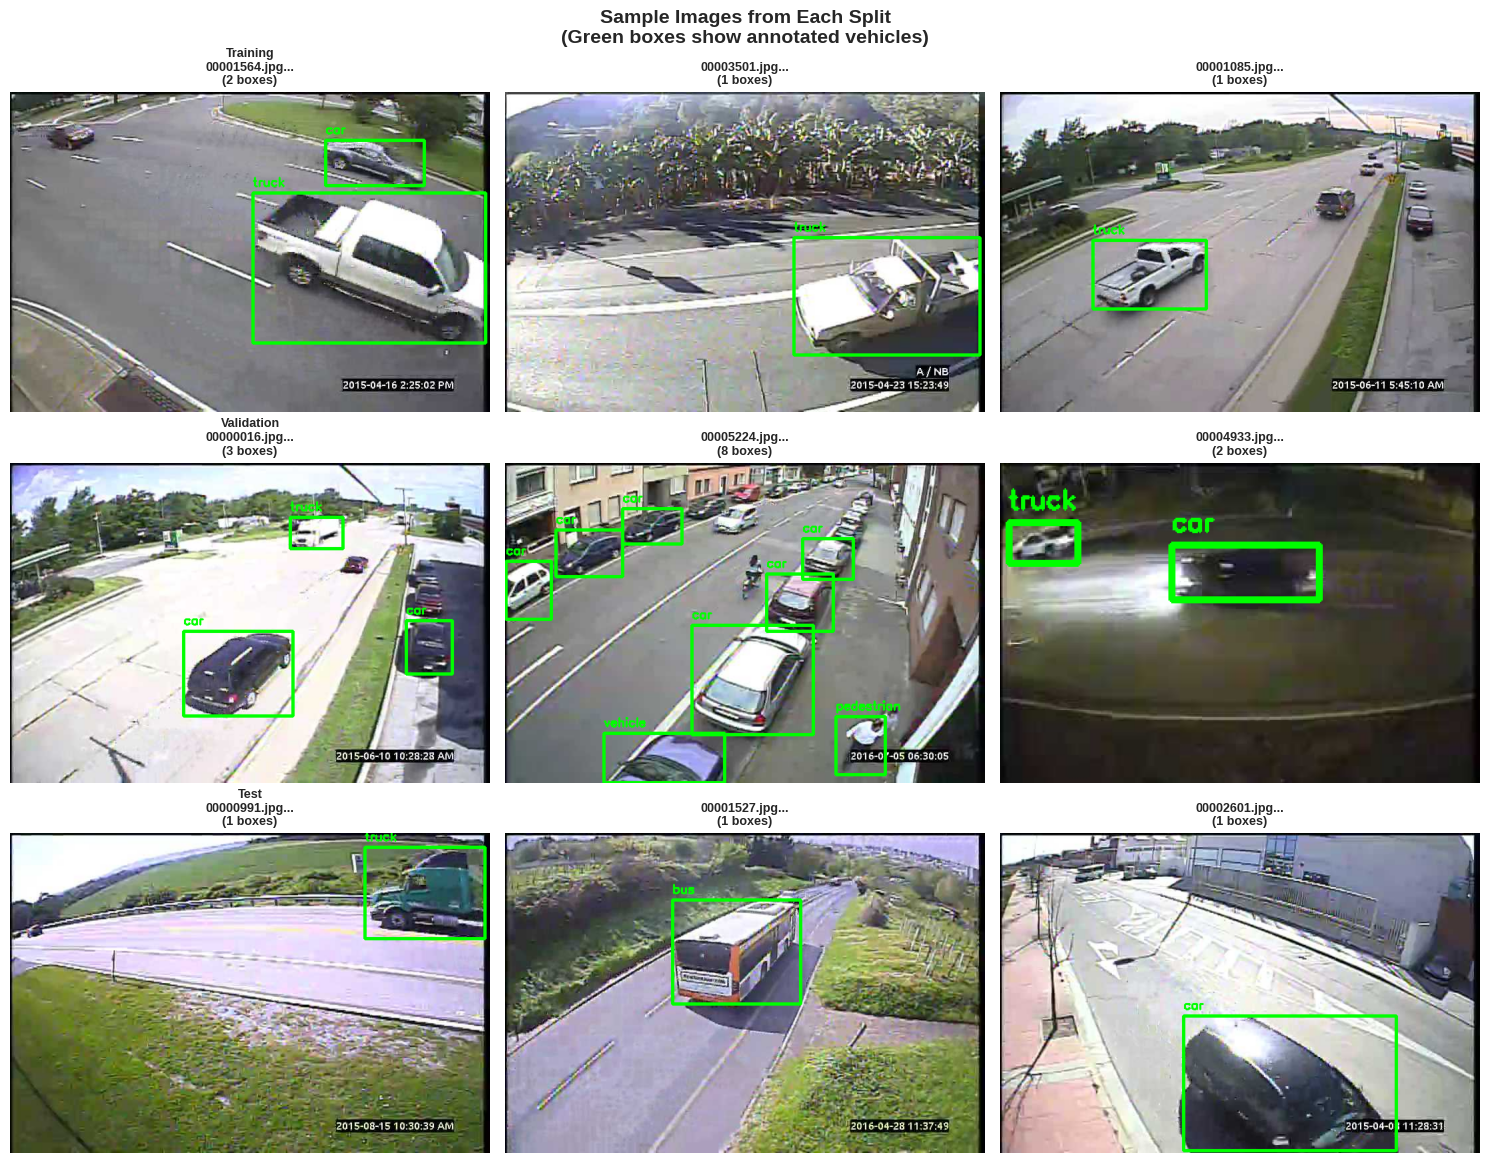


✓ Visualization complete!


In [ ]:
"""
Verify the split worked correctly and visualize samples from each set.
"""

def visualize_split_samples(train_dir, val_dir, test_dir, num_samples=3):
    """Visualize sample images from each split."""

    print("="*80)
    print("VISUALIZING SPLIT SAMPLES")
    print("="*80)

    splits = {
        "Training": (train_dir, DATA_DIR / "train_annotations.json"),
        "Validation": (val_dir, DATA_DIR / "val_annotations.json"),
        "Test": (test_dir, DATA_DIR / "test_annotations.json")
    }

    # Check all required files exist
    for split_name, (split_dir, annot_file) in splits.items():
        if not split_dir.exists():
            print(f"❌ {split_name} directory not found: {split_dir}")
            return
        if not annot_file.exists():
            print(f"❌ {split_name} annotations not found: {annot_file}")
            return

    print("All split directories and annotations found\n")

    # Create visualization
    fig, axes = plt.subplots(len(splits), num_samples, figsize=(15, 12))

    for row_idx, (split_name, (split_dir, annot_file)) in enumerate(splits.items()):
        # Load annotations
        with open(annot_file, "r") as f:
            annotations = json.load(f)

        print(f"{split_name} set: {len(annotations)} annotation entries")

        # KEY FIX: Get unique base filenames (not keys with _box suffix)
        unique_images = list(set([a["filename"] for a in annotations.values()]))
        print(f"  Unique images: {len(unique_images)}")

        # Get random sample of IMAGES (not annotation keys)
        available_samples = min(num_samples, len(unique_images))
        sample_images = np.random.choice(unique_images, available_samples, replace=False)

        for col_idx in range(num_samples):
            if col_idx < available_samples:
                image_filename = sample_images[col_idx]
                img_path = split_dir / image_filename

                if img_path.exists():
                    # Load image
                    img = cv2.imread(str(img_path))
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                    # KEY FIX: Find ALL boxes for this image
                    boxes_for_image = [
                        (key, annot) for key, annot in annotations.items()
                        if annot["filename"] == image_filename
                    ]

                    # Draw ALL bounding boxes for this image
                    for key, annot in boxes_for_image:
                        if "bbox" in annot:
                            bbox = annot["bbox"]
                            x_min, y_min, x_max, y_max = map(int, bbox)

                            # Draw box
                            cv2.rectangle(img_rgb, (x_min, y_min), (x_max, y_max),
                                        (0, 255, 0), 3)

                            # Add label
                            label = annot.get("label", "?")
                            cv2.putText(img_rgb, str(label), (x_min, y_min - 10),
                                      cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

                    # Display
                    if len(splits) > 1:
                        ax = axes[row_idx, col_idx]
                    else:
                        ax = axes[col_idx]

                    ax.imshow(img_rgb)
                    ax.axis("off")

                    # Title with box count
                    title = f"{image_filename[:20]}...\n({len(boxes_for_image)} boxes)"
                    if col_idx == 0:
                        title = f"{split_name}\n{title}"
                    ax.set_title(title, fontsize=9, fontweight="bold")
                else:
                    if len(splits) > 1:
                        ax = axes[row_idx, col_idx]
                    else:
                        ax = axes[col_idx]
                    ax.text(0.5, 0.5, "Image\nNot Found",
                           ha="center", va="center", fontsize=12)
                    ax.axis("off")
            else:
                # Empty subplot
                if len(splits) > 1:
                    ax = axes[row_idx, col_idx]
                else:
                    ax = axes[col_idx]
                ax.axis("off")

    plt.suptitle("Sample Images from Each Split\n(Green boxes show annotated vehicles)",
                fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.savefig(str(RESULTS_DIR / "split_samples.png"), dpi=300, bbox_inches="tight")
    plt.show()

    print("\n✓ Visualization complete!")


# Run visualization
try:
    visualize_split_samples(TRAIN_DIR, VAL_DIR, TEST_DIR, num_samples=3)
except Exception as e:
    print(f"❌ Error during visualization: {e}")
    import traceback
    traceback.print_exc()

In [ ]:
# ============================================================================
# METRICS & CALLBACKS
# ============================================================================
@tf.function # using decorator fn for perf increase
def IoU(y_true, y_pred):
    """Intersection over Union metric."""
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    x1 = tf.maximum(y_true[..., 0], y_pred[..., 0])
    y1 = tf.maximum(y_true[..., 1], y_pred[..., 1])
    x2 = tf.minimum(y_true[..., 2], y_pred[..., 2])
    y2 = tf.minimum(y_true[..., 3], y_pred[..., 3])

    inter = tf.maximum(0.0, x2 - x1) * tf.maximum(0.0, y2 - y1)
    area_true = (y_true[..., 2] - y_true[..., 0]) * (y_true[..., 3] - y_true[..., 1])
    area_pred = (y_pred[..., 2] - y_pred[..., 0]) * (y_pred[..., 3] - y_pred[..., 1])
    union = area_true + area_pred - inter + 1e-7

    return tf.reduce_mean(inter / union)

def get_callbacks(model_name="model"):
    """Get training callbacks."""
    return [
        EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-7, verbose=1),
        ModelCheckpoint(str(MODEL_DIR / f"best_{model_name}.keras"),
                       monitor="val_loss", save_best_only=True, verbose=1)
    ]

In [ ]:
# ============================================================================
# GRID SEARCH TRAINING
# ============================================================================
print("="*70)
print("GRID SEARCH TRAINING")
print("="*70)

# Hyperparameter grid
PARAM_GRID = {
    "backbone": ["mobilenet", "resnet50v2"],
    "learning_rate": [0.001, 0.0001],
    "batch_size": [32],
}

GRID_SEARCH_EPOCHS = 7
FINAL_TRAINING_EPOCHS = 50
BBOX_LOSS_WEIGHT = 10.0

combinations = list(ParameterGrid(PARAM_GRID))
print(f"Testing {len(combinations)} combinations: {combinations}\n")

# Store results and histories
all_results = []
all_histories = {}
best_models = {}

for i, params in enumerate(combinations):
    config_name = f"{params['backbone']}_lr{params['learning_rate']}"

    print(f"\n{'='*70}")
    print(f"[{i+1}/{len(combinations)}] {config_name}")
    print(f"{'='*70}")

    tf.keras.backend.clear_session() # clear old models & mem
    gc.collect()

    try:
        # Create generators
        train_gen = CropDataGenerator(
            CROPS_DIR, DATA_DIR / "train_crops.json", CLASS_MAP,
            batch_size=params["batch_size"], augment=True
        )
        val_gen = CropDataGenerator(
            CROPS_DIR, DATA_DIR / "val_crops.json", CLASS_MAP,
            batch_size=params["batch_size"], augment=False
        )

        print(f"Train: {len(train_gen.crops_info):,} samples, Val: {len(val_gen.crops_info):,} samples")

        # Create model (on pretrained)
        model = create_model(backbone=params["backbone"])
        # Configure model
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=params["learning_rate"]),
            loss={"bbox_output": "mse", "class_output": "sparse_categorical_crossentropy"},
            loss_weights={"bbox_output": BBOX_LOSS_WEIGHT, "class_output": 1.0},
            metrics={"bbox_output": [IoU], "class_output": ["accuracy"]}
        )

        print(f"Model params: {model.count_params():,}")

        # Train
        history = model.fit(
            train_gen,
            epochs=GRID_SEARCH_EPOCHS,
            validation_data=val_gen,
            callbacks=get_callbacks(config_name),
            verbose=1
        )

        # Store results
        best_val_loss = min(history.history["val_loss"])
        best_val_acc = max(history.history.get("val_class_output_accuracy", [0]))
        best_val_iou = max(history.history.get("val_bbox_output_IoU", [0]))

        all_results.append({
            "config": config_name,
            "backbone": params["backbone"],
            "learning_rate": params["learning_rate"],
            "val_loss": best_val_loss,
            "val_accuracy": best_val_acc,
            "val_iou": best_val_iou,
            "epochs_trained": len(history.history["loss"])
        })

        all_histories[config_name] = history.history
        best_models[config_name] = model

        print(f"\n✓ {config_name}: loss={best_val_loss:.4f}, acc={best_val_acc:.4f}, iou={best_val_iou:.4f}")

    except Exception as e:
        print(f"✗ ERROR: {e}")
        all_results.append({
            "config": config_name,
            "backbone": params["backbone"],
            "learning_rate": params["learning_rate"],
            "val_loss": float("inf"),
            "val_accuracy": 0,
            "val_iou": 0,
            "epochs_trained": 0
        })

# Actual Training (on 50 epochs):
# Retrain best configuration with full epochs
print(f"\n{'='*70}")
print(f"RETRAINING BEST CONFIG WITH {FINAL_TRAINING_EPOCHS} EPOCHS")
print(f"{'='*70}")

results_df = pd.DataFrame(all_results).sort_values("val_loss")
best_params = results_df.iloc[0]
tf.keras.backend.clear_session()
gc.collect()

train_gen = CropDataGenerator(
    CROPS_DIR, DATA_DIR / "train_crops.json", CLASS_MAP,
    batch_size=32, augment=True
)
val_gen = CropDataGenerator(
    CROPS_DIR, DATA_DIR / "val_crops.json", CLASS_MAP,
    batch_size=32, augment=False
)

best_model = create_model(backbone=best_params["backbone"])
best_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=best_params["learning_rate"]),
    loss={"bbox_output": "mse", "class_output": "sparse_categorical_crossentropy"},
    loss_weights={"bbox_output": BBOX_LOSS_WEIGHT, "class_output": 1.0},
    metrics={"bbox_output": [IoU], "class_output": ["accuracy"]}
)

best_history = best_model.fit(
    train_gen,
    epochs=FINAL_TRAINING_EPOCHS,
    validation_data=val_gen,
    callbacks=get_callbacks("final_best"),
    verbose=1
)

# Update histories and models for plotting
all_histories["final_best"] = best_history.history
best_models["final_best"] = best_model

print("\n" + "="*70)
print("GRID SEARCH COMPLETE")
print("="*70)

GRID SEARCH TRAINING
Testing 4 combinations: [{'backbone': 'mobilenet', 'batch_size': 32, 'learning_rate': 0.001}, {'backbone': 'mobilenet', 'batch_size': 32, 'learning_rate': 0.0001}, {'backbone': 'resnet50v2', 'batch_size': 32, 'learning_rate': 0.001}, {'backbone': 'resnet50v2', 'batch_size': 32, 'learning_rate': 0.0001}]


[1/4] mobilenet_lr0.001
Train: 7,102 samples, Val: 1,521 samples
Model params: 3,048,268
Epoch 1/7
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - bbox_output_IoU: 0.7378 - bbox_output_loss: 0.0090 - class_output_accuracy: 0.6367 - class_output_loss: 1.1323 - loss: 1.3282
Epoch 1: val_loss improved from inf to 7.15494, saving model to /content/vehicle_project/vehicle_detection_project/models/best_mobilenet_lr0.001.keras
222/222 ━━━━━━━━━━━━━━━━━━━━ 107s 461ms/step - bbox_output_IoU: 0.7379 - bbox_output_loss: 0.0090 - class_output_accuracy: 0.6370 - class_output_loss: 1.1313 - loss: 1.3270 - val_bbox_output_IoU: 0.7198 - val_bbox_output_loss: 0.0060 - val_class_outpu

In [ ]:
# ============================================================================
# RESULTS SUMMARY TABLE
# ============================================================================
print("="*70)
print("GRID SEARCH RESULTS")
print("="*70)

results_df = pd.DataFrame(all_results).sort_values("val_loss")
print(results_df.to_string(index=False))

# Best configuration
best_config = results_df.iloc[0]
print(f"\n🏆 BEST CONFIGURATION:")
print(f"   Config: {best_config['config']}")
print(f"   Val Loss: {best_config['val_loss']:.4f}")
print(f"   Val Accuracy: {best_config['val_accuracy']:.4f}")
print(f"   Val IoU: {best_config['val_iou']:.4f}")

# Save results
results_df.to_csv(RESULTS_DIR / "grid_search_results.csv", index=False)
print(f"Results saved to {RESULTS_DIR / 'grid_search_results.csv'}")

GRID SEARCH RESULTS
             config   backbone  learning_rate  val_loss  val_accuracy  val_iou  epochs_trained
 resnet50v2_lr0.001 resnet50v2         0.0010  0.523319      0.867193 0.878167               7
resnet50v2_lr0.0001 resnet50v2         0.0001  0.657638      0.848126 0.791878               7
 mobilenet_lr0.0001  mobilenet         0.0001  0.784684      0.816568 0.753728               7
  mobilenet_lr0.001  mobilenet         0.0010  1.804114      0.748192 0.793604               7

🏆 BEST CONFIGURATION:
   Config: resnet50v2_lr0.001
   Val Loss: 0.5233
   Val Accuracy: 0.8672
   Val IoU: 0.8782

✓ Results saved to /content/vehicle_project/vehicle_detection_project/results/grid_search_results.csv


In [ ]:
# ============================================================================
# EVALUATE BEST MODEL ON TEST SET
# ============================================================================
print("="*70)
print("EVALUATING BEST MODEL ON TEST SET")
print("="*70)

best_model = best_models["final_best"]

test_gen = CropDataGenerator(
    CROPS_DIR, DATA_DIR / "test_crops.json", CLASS_MAP,
    batch_size=32, augment=False, include_bbox=True
)

print(f"Test samples: {len(test_gen.crops_info):,}")

# Evaluate
test_results = best_model.evaluate(test_gen, verbose=1, return_dict=True)

print("\nTest Results:")
for name, value in test_results.items():
    print(f"  {name}: {value:.4f}")

# Classification report
y_true, y_pred = [], []
for i in range(len(test_gen)):
    X, y = test_gen[i]
    preds = best_model.predict(X, verbose=0)
    y_true.extend(y["class_output"].tolist())
    y_pred.extend(np.argmax(preds["class_output"], axis=1).tolist())

y_true, y_pred = np.array(y_true), np.array(y_pred)
unique_labels = np.unique(y_true)
target_names = [CLASS_NAMES[i] for i in unique_labels if i < len(CLASS_NAMES)]

print("\nClassification Report:")
print(classification_report(y_true, y_pred, labels=unique_labels[:len(target_names)],
                           target_names=target_names, digits=3, zero_division=0))

EVALUATING BEST MODEL ON TEST SET
Test samples: 1,523
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 413ms/step - bbox_output_IoU: 0.8817 - bbox_output_loss: 0.0013 - class_output_accuracy: 0.8529 - class_output_loss: 0.4496 - loss: 0.5228

Test Results:
  bbox_output_IoU: 0.8851
  bbox_output_loss: 0.0012
  class_output_accuracy: 0.8529
  class_output_loss: 0.4482
  loss: 0.5157

Classification Report:
              precision    recall  f1-score   support

     bicycle      0.889     0.533     0.667        15
         bus      0.885     0.896     0.890        77
         car      0.886     0.939     0.912       945
  motorcycle      0.538     0.778     0.636         9
  pedestrian      0.783     0.947     0.857        19
       truck      0.884     0.734     0.802       354
         van      0.380     0.543     0.447        35
     vehicle      0.564     0.449     0.500        69

    accuracy                          0.853      1523
   macro avg      0.726     0.727     0.714      1523
weighted avg 

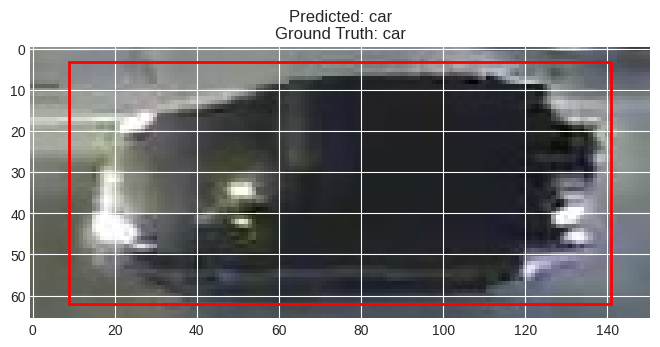

In [ ]:
# Load a test crop and predict
# Testing inference

test_crop = random.choice(test_gen.crops_info)
img = cv2.imread(str(CROPS_DIR / test_crop["crop_filename"]))
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_input = cv2.resize(img_rgb, (224, 224)) / 255.0
img_input = np.expand_dims(img_input, axis=0)

# Predict
pred = best_model.predict(img_input, verbose=0)
pred_bbox = pred["bbox_output"][0]
pred_class = CLASS_NAMES[np.argmax(pred["class_output"][0])]

# Draw prediction
h, w = img_rgb.shape[:2]
x1, y1 = int(pred_bbox[0] * w), int(pred_bbox[1] * h)
x2, y2 = int(pred_bbox[2] * w), int(pred_bbox[3] * h)

plt.figure(figsize=(8, 6))
plt.imshow(img_rgb)
plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, color="red", linewidth=2))
plt.title(f"Predicted: {pred_class}\nGround Truth: {test_crop['label']}")
plt.show()

TRAINING CURVES


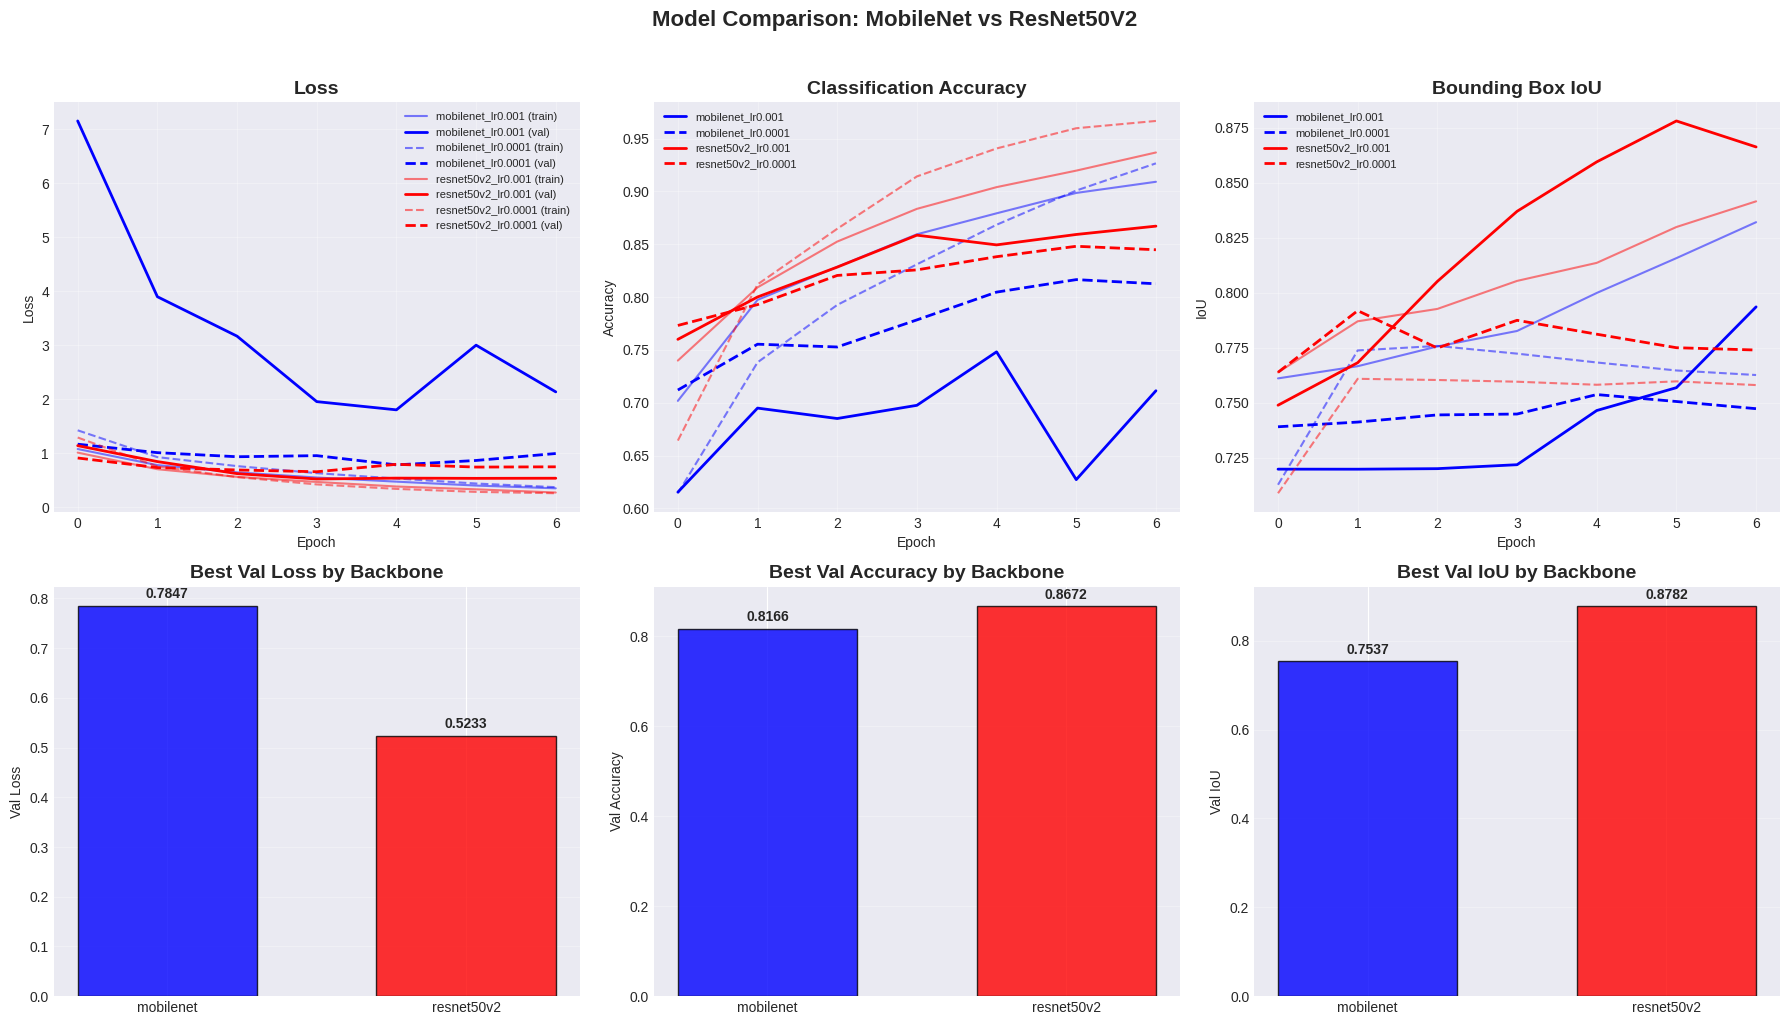


✓ Plot saved to /content/vehicle_project/vehicle_detection_project/results/model_comparison.png


In [ ]:
# ============================================================================
# TRAINING CURVES FOR ALL CONFIGURATIONS
# ============================================================================
print("="*70)
print("TRAINING CURVES")
print("="*70)

# Get unique backbones for comparison
backbones = results_df["backbone"].unique()
colors = {"mobilenet": "blue", "resnet50v2": "red"}
linestyles = {0.001: "-", 0.0001: "--"}

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Row 1: Training curves
# Loss
ax = axes[0, 0]
for config_name, hist in all_histories.items():
    if config_name == "final_best":
        continue  # Skip final_best, plot grid search configs only
    backbone = config_name.split("_lr")[0]
    lr = float(config_name.split("_lr")[1])
    ax.plot(hist["loss"], color=colors[backbone], linestyle=linestyles[lr],
            alpha=0.5, label=f"{config_name} (train)")
    ax.plot(hist["val_loss"], color=colors[backbone], linestyle=linestyles[lr],
            linewidth=2, label=f"{config_name} (val)")
ax.set_title("Loss", fontsize=14, fontweight="bold")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend(fontsize=8)
ax.grid(alpha=0.3)

# Accuracy
ax = axes[0, 1]
for config_name, hist in all_histories.items():
    if config_name == "final_best":
        continue  # Skip final_best, plot grid search configs only
    backbone = config_name.split("_lr")[0]
    lr = float(config_name.split("_lr")[1])
    if "class_output_accuracy" in hist:
        ax.plot(hist["class_output_accuracy"], color=colors[backbone], linestyle=linestyles[lr],
                alpha=0.5)
        ax.plot(hist["val_class_output_accuracy"], color=colors[backbone], linestyle=linestyles[lr],
                linewidth=2, label=f"{config_name}")
ax.set_title("Classification Accuracy", fontsize=14, fontweight="bold")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.legend(fontsize=8)
ax.grid(alpha=0.3)

# IoU
ax = axes[0, 2]
for config_name, hist in all_histories.items():
    if config_name == "final_best":
        continue  # Skip final_best, plot grid search configs only
    backbone = config_name.split("_lr")[0]
    lr = float(config_name.split("_lr")[1])
    if "bbox_output_IoU" in hist:
        ax.plot(hist["bbox_output_IoU"], color=colors[backbone], linestyle=linestyles[lr],
                alpha=0.5)
        ax.plot(hist["val_bbox_output_IoU"], color=colors[backbone], linestyle=linestyles[lr],
                linewidth=2, label=f"{config_name}")
ax.set_title("Bounding Box IoU", fontsize=14, fontweight="bold")
ax.set_xlabel("Epoch")
ax.set_ylabel("IoU")
ax.legend(fontsize=8)
ax.grid(alpha=0.3)

# Row 2: Bar charts comparing backbones
# Group results by backbone (best LR for each)
backbone_best = results_df.groupby("backbone").apply(lambda x: x.loc[x["val_loss"].idxmin()]).reset_index(drop=True)

x = np.arange(len(backbone_best))
width = 0.6

# Loss comparison
ax = axes[1, 0]
bars = ax.bar(x, backbone_best["val_loss"], width, color=[colors[b] for b in backbone_best["backbone"]],
              edgecolor="black", alpha=0.8)
ax.set_title("Best Val Loss by Backbone", fontsize=14, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(backbone_best["backbone"])
ax.set_ylabel("Val Loss")
for bar, val in zip(bars, backbone_best["val_loss"]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f"{val:.4f}",
            ha="center", va="bottom", fontweight="bold")
ax.grid(axis="y", alpha=0.3)

# Accuracy comparison
ax = axes[1, 1]
bars = ax.bar(x, backbone_best["val_accuracy"], width, color=[colors[b] for b in backbone_best["backbone"]],
              edgecolor="black", alpha=0.8)
ax.set_title("Best Val Accuracy by Backbone", fontsize=14, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(backbone_best["backbone"])
ax.set_ylabel("Val Accuracy")
for bar, val in zip(bars, backbone_best["val_accuracy"]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f"{val:.4f}",
            ha="center", va="bottom", fontweight="bold")
ax.grid(axis="y", alpha=0.3)

# IoU comparison
ax = axes[1, 2]
bars = ax.bar(x, backbone_best["val_iou"], width, color=[colors[b] for b in backbone_best["backbone"]],
              edgecolor="black", alpha=0.8)
ax.set_title("Best Val IoU by Backbone", fontsize=14, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(backbone_best["backbone"])
ax.set_ylabel("Val IoU")
for bar, val in zip(bars, backbone_best["val_iou"]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f"{val:.4f}",
            ha="center", va="bottom", fontweight="bold")
ax.grid(axis="y", alpha=0.3)

plt.suptitle("Model Comparison: MobileNet vs ResNet50V2", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig(RESULTS_DIR / "model_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"\n✓ Plot saved to {RESULTS_DIR / 'model_comparison.png'}")

In [ ]:
# ============================================================================
# FINAL SUMMARY REPORT
# ============================================================================
print("="*70)
print("FINAL SUMMARY REPORT")
print("="*70)

print("\n📊 GRID SEARCH RESULTS:")
print(results_df[["config", "val_loss", "val_accuracy", "val_iou", "epochs_trained"]].to_string(index=False))

print(f"\n🏆 BEST CONFIGURATION: {best_config['config']}")
print(f"   Backbone: {best_config['backbone']}")
print(f"   Learning Rate: {best_config['learning_rate']}")
print(f"   Val Loss: {best_config['val_loss']:.4f}")
print(f"   Val Accuracy: {best_config['val_accuracy']:.4f}")
print(f"   Val IoU: {best_config['val_iou']:.4f}")

print(f"\n📈 TEST SET RESULTS (Best Model):")
for name, value in test_results.items():
    print(f"   {name}: {value:.4f}")

print(f"\n📁 SAVED FILES:")
print(f"   Models: {MODEL_DIR}")
print(f"   Results: {RESULTS_DIR / 'grid_search_results.csv'}")
print(f"   Plots: {RESULTS_DIR / 'model_comparison.png'}")

# Save best model
best_model.save(MODEL_DIR / "final_best_model.keras")
print(f"   Final Model: {MODEL_DIR / 'final_best_model.keras'}")

print("\n" + "="*70)
print("✓ COMPLETE!")
print("="*70)

FINAL SUMMARY REPORT

📊 GRID SEARCH RESULTS:
             config  val_loss  val_accuracy  val_iou  epochs_trained
 resnet50v2_lr0.001  0.523319      0.867193 0.878167               7
resnet50v2_lr0.0001  0.657638      0.848126 0.791878               7
 mobilenet_lr0.0001  0.784684      0.816568 0.753728               7
  mobilenet_lr0.001  1.804114      0.748192 0.793604               7

🏆 BEST CONFIGURATION: resnet50v2_lr0.001
   Backbone: resnet50v2
   Learning Rate: 0.001
   Val Loss: 0.5233
   Val Accuracy: 0.8672
   Val IoU: 0.8782

📈 TEST SET RESULTS (Best Model):
   bbox_output_IoU: 0.8851
   bbox_output_loss: 0.0012
   class_output_accuracy: 0.8529
   class_output_loss: 0.4482
   loss: 0.5157

📁 SAVED FILES:
   Models: /content/vehicle_project/vehicle_detection_project/models
   Results: /content/vehicle_project/vehicle_detection_project/results/grid_search_results.csv
   Plots: /content/vehicle_project/vehicle_detection_project/results/model_comparison.png
   Final Model: /con

In [ ]:
!cp -r /content/vehicle_detection_project/results/ "/content/drive/MyDrive/Colab Results/"


cp: cannot stat '/content/vehicle_detection_project/results/': No such file or directory
